#IMDB Sentiment Analysis - Logistic Regression Model
Georgios - Alexandros Vasilakopoulos

##Loading the data:

In [ ]:
import numpy as np
import torchtext as text
import torch
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

In [ ]:
data_path = 'drive/MyDrive/ML/AI2/imdb-reviews.csv'
test_path = None #Insert the path here for testing and load the model in the RNN section


if test_path:
    test_dataset = pd.read_csv(test_path, sep = '\t')
    X_test = test_dataset['review']
    Y_test = test_dataset[['rating']]
    Y_test.loc[Y_test['rating'] < 7.0, 'rating']=0
    Y_test.loc[Y_test['rating'] >= 7.0, 'rating']=1
else:
    data = pd.read_csv(data_path, sep = '\t')
    X = data['review']
    Y = data[['rating']]

    Y.loc[Y['rating'] < 7.0, 'rating']=0
    Y.loc[Y['rating'] >= 7.0, 'rating']=1

    X,X_test,Y,Y_test = train_test_split(X,Y,test_size=0.2, shuffle = True) #Partition of the dataset
    X,X_validation,Y,Y_validation = train_test_split(X,Y,test_size=0.2, shuffle = True)

##Data Preprocessing

###Defining a custom Dataset

In [ ]:
from torch.utils.data import Dataset
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

class myDataset(Dataset):
    def __init__(self,X,Y,vec):                 #vec corresponds to a word2vec vocabulary. In our case, GloVe embeddings
        self.vec = vec
        stopword_set = set(stopwords.words())

        X_transformed = []
        for instance in X:
            instance = re.sub(r'[^a-z ]+', '', instance.lower())        #Transform upper case letters to lower case and keep only letters.
            word_list = word_tokenize(instance)
            word_list = [word for word in word_list if not word in stopword_set]
            vector_list = []
            for word in word_list:
                if word in self.vec.stoi:                            #If word is in vocabulary, add the index of the word for later reference
                    vector_list.append(self.vec.stoi[word])
            if len(vector_list)>0:
                X_transformed.append(torch.tensor(vector_list))


        self.X = X_transformed              #Store data within the myDataset object
        self.Y = np.ravel(Y)


    def __len__(self):
        return len(self.Y)

    def getLabels(self):
        return self.Y

    def __getitem__(self,idx):
        return self.X[idx], self.Y[idx]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


###Initialize Dataloaders

In [ ]:
vec = text.vocab.GloVe(name='6B', dim=300)

.vector_cache/glove.6B.zip: 862MB [05:11, 2.77MB/s]                           
100%|█████████▉| 399999/400000 [00:35<00:00, 11314.01it/s]


In [ ]:
if test_path is None:
    train_dataset = myDataset(X,Y,vec)
    validation_dataset = myDataset(X_validation,Y_validation,vec)
test_dataset = myDataset(X_test,Y_test,vec)

In [ ]:
def collate_fn(batch):      #Given a batch, pad the data and return the padded data and the labels

    (X, Y) = zip(*batch)

    X_padded = torch.nn.utils.rnn.pad_sequence(X,batch_first=True)
    return X_padded,torch.tensor(list(Y),dtype=torch.float)

if test_path is None:
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True,collate_fn = collate_fn)
    validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=64, shuffle=False,collate_fn = collate_fn)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False,collate_fn = collate_fn)


##Recurrent Neural Network

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 28.8 MB/s eta 0:00:00


In [ ]:
import torch.nn as nn
from torchmetrics.classification import BinaryF1Score
from torchmetrics.classification import BinaryPrecision
from torchmetrics.classification import BinaryRecall
import matplotlib.pyplot as plt

###Defining the RNN architecture

In [ ]:
class RNN(nn.Module):
    """
      Wrapper module for RNN, LSTM, GRU cells using pytorch api. The output is fed to a FFN for classification.
    """
    # def __init__(self, cell_type, input_size, hidden_size,num_layers, dropout, output_size,vec):
    def __init__(self, parameters,vec,output_size=1):
        super(RNN, self).__init__()

        cells = {
        "LSTM"    : nn.LSTM,
        "GRU"     : nn.GRU
    }
        self.vec = vec
        self.embedding = nn.Embedding.from_pretrained(vec.vectors)
        self.cell_type = parameters['cell_type']
        self.skip_connections = parameters['skip_connections']


        self.rnn_layers = nn.ModuleList()
        self.rnn_layers = self.rnn_layers.append(cells[parameters['cell_type']](
            input_size = parameters['input_size'],
            hidden_size = parameters['hidden_size'],
            dropout = parameters['dropout'],
            bidirectional = True,
            batch_first =  True,
        ))
        i = 1
        while i < parameters['num_layers']:
            self.rnn_layers.append(
                cells[parameters['cell_type']](
                    input_size = 2*parameters['hidden_size'],
                    hidden_size =parameters['hidden_size'],
                    dropout = parameters['dropout'],
                    bidirectional = True,
                    batch_first =  True,
                )
            )
            i+=1

        self.use_attention = parameters['attention']
        if self.use_attention == True:
            self.out = nn.Linear(4*parameters['hidden_size'], output_size)
        else:
            self.out = nn.Linear(2*parameters['hidden_size'], output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        out = self.embedding(x)
        if self.skip_connections == True and len(self.rnn_layers)>1:
            out1,_ = self.rnn_layers[0](out)
            out2,_ = self.rnn_layers[1](out1)
            for i in range(2,len(self.rnn_layers)):
                temp,_ = self.rnn_layers[i](out1 + out2)
                out1 = out2
                out2 = temp
            out = out2

        else:
            for i in range(len(self.rnn_layers)):
                out,_ = self.rnn_layers[i](out)



        if self.use_attention == True:
            softmax = nn.Softmax()
            weight_vectors = []
            for i in range(out.shape[0]):                                               #For each batch
                weight_vector = softmax(torch.matmul(out[i,0:-2,:],out[i,-1,:]))        #Compute weight vector
                vector = torch.matmul(out[i,0:-2,:].T,weight_vector)                    #Compute weighted sum of vectors
                weight_vectors.append(torch.cat((vector,out[i,-1,:]),0))
            weight_vectors = torch.stack(weight_vectors)
            return self.sigmoid(self.out(weight_vectors))
        else:
            return self.sigmoid(self.out(out[:,-1,:]))

###Defining the Train, Test and Make Prediction Processes

In [ ]:
def Test_Network(dataloader, model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    f1 = BinaryF1Score().to(device)
    pr = BinaryPrecision().to(device)
    rec = BinaryRecall().to(device)

    with torch.no_grad():
        model.eval()
        batch_counter = 0
        f1_measure = 0
        precision = 0
        recall = 0
        for batch_id, (x,y) in enumerate(dataloader):
            x = x.to(device)
            y = y.to(device)

            prediction = model(x)
            prediction = prediction[:,0]
            f1_measure += f1(prediction,y)
            precision += pr(prediction,y)
            recall += rec(prediction,y)
            batch_counter +=1

        f1_measure/= batch_counter
        precision /= batch_counter
        recall /= batch_counter

    return precision, recall, f1_measure

In [ ]:
def Train_Network(train_dataloader,validation_dataloader,n_epochs,lr,model,info=False):
    cost_function = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        print("Using cuda")
        model = model.cuda()
        cost_function = cost_function.cuda()
    else:
        print("Using CPU")

    best_model = None
    highest_f1_score = 0

    epoch_sizes = []
    val_scores = []
    train_scores = []

    for i in range(n_epochs):
        model.train()
        loss_list = []
        avg_losses = []
        for batch_id, (x,y) in enumerate(train_dataloader):
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            prediction = model(x)
            loss = cost_function(prediction[:,0],y)
            loss_list.append(loss.item())
            loss.backward()
            optimizer.step()

        _,_,f1_measure_val = Test_Network(validation_dataloader,model)
        if info == True:
            _, _, f1_measure_train = Test_Network(train_dataloader,model)
            epoch_sizes.append([i])
            val_scores.append(f1_measure_val.item())
            train_scores.append(f1_measure_train.item())
            avg_losses.append(np.mean(loss_list))
        if highest_f1_score < f1_measure_val:
            highest_f1_score = f1_measure_val
            best_model = model
    if info == False:
        return best_model, highest_f1_score
    return best_model, avg_losses, epoch_sizes, val_scores, train_scores



In [ ]:
def make_prediction(test_dataloader,model):
    def toBinary(x):
        if x >=0.5 :
            return 1
        else:
            return 0

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    predictions = []
    with torch.no_grad():
        model.eval()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        for batch_id, (x,_) in enumerate(test_dataloader):
            x = x.to(device)
            prediction = model(x)
            prediction = prediction[:,0]
            predictions.append(np.array(prediction.cpu()))
        predictions = np.concatenate(predictions)
        quantized = []
        for val in predictions:
            if val>=0.5:
                quantized.append(1)
            else:
                quantized.append(0)

    return np.array(quantized)


###Defining the final model:

In [ ]:
parameters = {
    'lr': 0.0008597490589482921,
    'cell_type': 'LSTM',
    'input_size': 300,
    'hidden_size': 57,
    'num_layers': 3,
    'dropout': 0.02051594089032721,
    'skip_connections' : False,
    'attention' : True
}

net = RNN(parameters,vec)
print(net)

RNN(
  (embedding): Embedding(400000, 300)
  (rnn_layers): ModuleList(
    (0): LSTM(300, 57, batch_first=True, dropout=0.02051594089032721, bidirectional=True)
    (1): LSTM(114, 57, batch_first=True, dropout=0.02051594089032721, bidirectional=True)
    (2): LSTM(114, 57, batch_first=True, dropout=0.02051594089032721, bidirectional=True)
  )
  (out): Linear(in_features=228, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.02051594089032721 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


###TRAIN THE MODEL

In [ ]:
EPOCH = 7
trained_model, avg_losses, epoch_sizes, val_scores, train_scores = Train_Network(train_dataloader,validation_dataloader,EPOCH, parameters['lr'], net,info = True)

Using cuda


<ipython-input-8-5f83bf2eb6bd>:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weight_vector = softmax(torch.matmul(out[i,0:-2,:],out[i,-1,:]))        #Compute weight vector


In [ ]:
torch.save(trained_model.state_dict(),'drive/MyDrive/ML/AI2/mymodel.pt')

###OR LOAD THE MODEL

In [ ]:
MODEL_PATH = 'drive/MyDrive/ML/AI2/mymodel.pt'

trained_model = net
trained_model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

###Performance on the Test set: Metrics, Learning Curve, ROC Curve

In [ ]:
precision, recall, f1 = Test_Network(test_dataloader,trained_model)
print("Precision: ",precision.item())
print("Recall: ",recall.item())
print("f1 measure: ",f1.item())

y_predicted = make_prediction(test_dataloader,trained_model)
y_actual = np.asarray(test_dataset.getLabels())

<ipython-input-8-5f83bf2eb6bd>:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weight_vector = softmax(torch.matmul(out[i,0:-2,:],out[i,-1,:]))        #Compute weight vector


Precision:  0.8549545407295227
Recall:  0.8871859312057495
f1 measure:  0.8690437078475952


The code below will work if the model is trained within the current runtime.

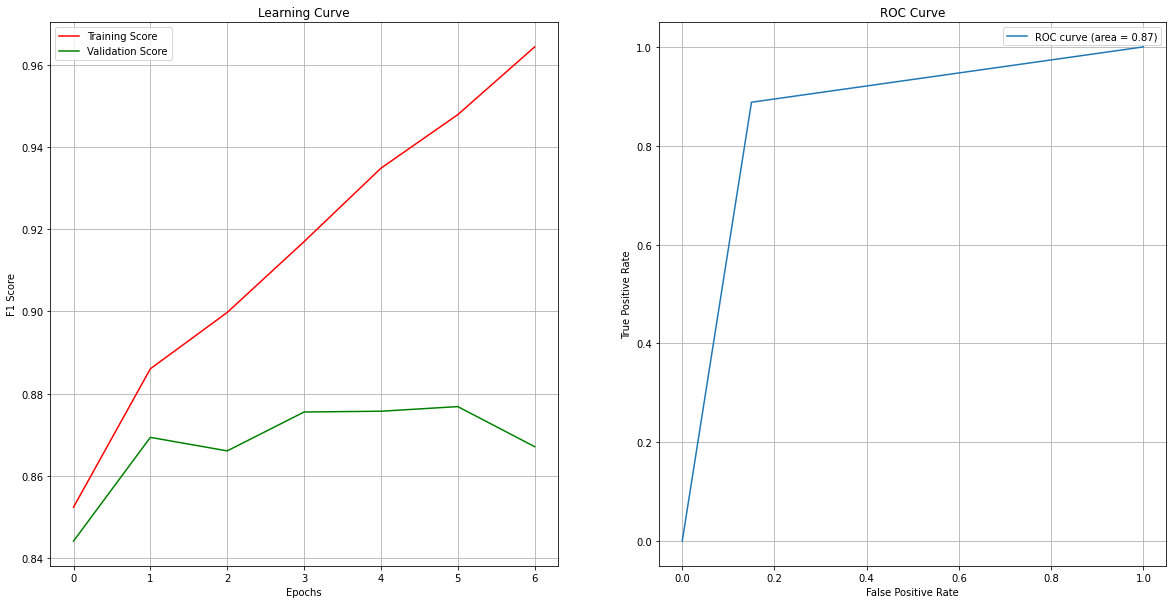

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc



fp,tp,_ = roc_curve(y_actual, y_predicted)
roc_auc = auc(fp,tp)

_, axes = plt.subplots(1,2,figsize=(20,10))
axes[0].set_title("Learning Curve")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("F1 Score")
axes[0].grid()

axes[0].plot(epoch_sizes, train_scores, color="r", label="Training Score")
axes[0].plot(epoch_sizes, val_scores, color="g", label="Validation Score")
axes[0].legend(loc="best")

axes[1].set_title("ROC Curve")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].grid()
axes[1].plot(fp, tp, label='ROC curve (area = %0.2f)' % roc_auc)
axes[1].legend(loc = "best")


##Hyperparameter Selection

###Optuna Installation

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.5/348.5 KB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 KB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.1/147.1 KB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 KB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 KB 13.9 MB/s eta 0:00:00
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=4285d9860ce093364efb29a9ebd75cccdfcdfba0ae65a775410b78c7c12f1787
  Stored in directory: /root/.cache/pip/wheels/7f/1a/65/84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip
  

In [ ]:
import optuna

###Searching for the best model: Without Attention

In [ ]:
def objective(trial):

    parameters = {
        'lr': trial.suggest_loguniform('learning_rate',1e-4,1e-2),
        'cell_type': trial.suggest_categorical("cell_type",["LSTM","GRU"]),
        'input_size': 300,
        'hidden_size': trial.suggest_int("hidden_size",16,64),
        'num_layers': trial.suggest_int("num_layers",1,10),
        'dropout': trial.suggest_loguniform("dropout",0.01,0.08),
        'skip_connections': True,
        'attention': False
    }
    EPOCH = 15


    model= RNN(parameters,vec)

    _,f1_measure = Train_Network(train_dataloader,validation_dataloader,EPOCH,parameters['lr'],model)

    return f1_measure

####Optuna Results:

In [ ]:
study = optuna.create_study(direction = "maximize", sampler = optuna.samplers.TPESampler())
study.optimize(objective, n_trials = 70)

[I 2023-01-16 13:28:29,249] A new study created in memory with name: no-name-c56e2989-4902-4997-af61-04932791c58b
<ipython-input-57-ee9d883959aa>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lr': trial.suggest_loguniform('learning_rate',1e-4,1e-2),
<ipython-input-57-ee9d883959aa>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'dropout': trial.suggest_loguniform("dropout",0.01,0.08),
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.03346328584992909 and num_layers=1
  warni

Using cuda


[I 2023-01-16 13:32:14,635] Trial 0 finished with value: 0.8728100061416626 and parameters: {'learning_rate': 0.00043681250784569385, 'cell_type': 'GRU', 'hidden_size': 41, 'num_layers': 6, 'dropout': 0.03346328584992909}. Best is trial 0 with value: 0.8728100061416626.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.01141540953855738 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 13:38:45,233] Trial 1 finished with value: 0.801502525806427 and parameters: {'learning_rate': 0.00010874979889551688, 'cell_type': 'LSTM', 'hidden_size': 42, 'num_layers': 10, 'dropout': 0.01141540953855738}. Best is trial 0 with value: 0.8728100061416626.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.017362485726731824 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 13:44:35,920] Trial 2 finished with value: 0.8679660558700562 and parameters: {'learning_rate': 0.0016268676311938463, 'cell_type': 'GRU', 'hidden_size': 64, 'num_layers': 7, 'dropout': 0.017362485726731824}. Best is trial 0 with value: 0.8728100061416626.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.01850950562006979 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 13:47:40,072] Trial 3 finished with value: 0.8537068367004395 and parameters: {'learning_rate': 0.0032440805798512606, 'cell_type': 'LSTM', 'hidden_size': 43, 'num_layers': 4, 'dropout': 0.01850950562006979}. Best is trial 0 with value: 0.8728100061416626.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.02193901400695759 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 13:52:47,777] Trial 4 finished with value: 0.8511274456977844 and parameters: {'learning_rate': 0.009020712119013858, 'cell_type': 'GRU', 'hidden_size': 39, 'num_layers': 9, 'dropout': 0.02193901400695759}. Best is trial 0 with value: 0.8728100061416626.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.07226872317553729 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 13:54:41,336] Trial 5 finished with value: 0.8632097244262695 and parameters: {'learning_rate': 0.008406777755339816, 'cell_type': 'GRU', 'hidden_size': 52, 'num_layers': 2, 'dropout': 0.07226872317553729}. Best is trial 0 with value: 0.8728100061416626.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.025168282579724102 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 13:59:42,986] Trial 6 finished with value: 0.8649165034294128 and parameters: {'learning_rate': 0.0010538090722653811, 'cell_type': 'GRU', 'hidden_size': 57, 'num_layers': 6, 'dropout': 0.025168282579724102}. Best is trial 0 with value: 0.8728100061416626.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.021953097995575335 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 14:03:05,157] Trial 7 finished with value: 0.6684850454330444 and parameters: {'learning_rate': 0.002931883694961091, 'cell_type': 'LSTM', 'hidden_size': 20, 'num_layers': 9, 'dropout': 0.021953097995575335}. Best is trial 0 with value: 0.8728100061416626.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.04286214703844243 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 14:06:32,523] Trial 8 finished with value: 0.8717403411865234 and parameters: {'learning_rate': 0.0066190487743544675, 'cell_type': 'GRU', 'hidden_size': 55, 'num_layers': 4, 'dropout': 0.04286214703844243}. Best is trial 0 with value: 0.8728100061416626.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.029375871591227457 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 14:07:47,069] Trial 9 finished with value: 0.8630489110946655 and parameters: {'learning_rate': 0.002267769246139344, 'cell_type': 'GRU', 'hidden_size': 28, 'num_layers': 2, 'dropout': 0.029375871591227457}. Best is trial 0 with value: 0.8728100061416626.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.045288750799928036 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 14:10:53,382] Trial 10 finished with value: 0.8438441753387451 and parameters: {'learning_rate': 0.00029549066272782057, 'cell_type': 'LSTM', 'hidden_size': 30, 'num_layers': 7, 'dropout': 0.045288750799928036}. Best is trial 0 with value: 0.8728100061416626.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.03873866659216112 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 14:14:05,985] Trial 11 finished with value: 0.871421754360199 and parameters: {'learning_rate': 0.0003918414157153518, 'cell_type': 'GRU', 'hidden_size': 51, 'num_layers': 4, 'dropout': 0.03873866659216112}. Best is trial 0 with value: 0.8728100061416626.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.05641170436457219 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 14:17:36,508] Trial 12 finished with value: 0.8645263910293579 and parameters: {'learning_rate': 0.00046306164124151384, 'cell_type': 'GRU', 'hidden_size': 64, 'num_layers': 4, 'dropout': 0.05641170436457219}. Best is trial 0 with value: 0.8728100061416626.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.034569929238495146 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 14:20:31,082] Trial 13 finished with value: 0.8665132522583008 and parameters: {'learning_rate': 0.00018299685030887775, 'cell_type': 'GRU', 'hidden_size': 34, 'num_layers': 5, 'dropout': 0.034569929238495146}. Best is trial 0 with value: 0.8728100061416626.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.05888714843828612 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 14:21:45,978] Trial 14 finished with value: 0.8674743175506592 and parameters: {'learning_rate': 0.0008093996492849836, 'cell_type': 'GRU', 'hidden_size': 49, 'num_layers': 1, 'dropout': 0.05888714843828612}. Best is trial 0 with value: 0.8728100061416626.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.04563100461318768 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 14:26:46,784] Trial 15 finished with value: 0.866557240486145 and parameters: {'learning_rate': 0.005183310703907376, 'cell_type': 'GRU', 'hidden_size': 57, 'num_layers': 6, 'dropout': 0.04563100461318768}. Best is trial 0 with value: 0.8728100061416626.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.07971027416729584 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 14:28:13,711] Trial 16 finished with value: 0.8705813884735107 and parameters: {'learning_rate': 0.0007745276790536784, 'cell_type': 'GRU', 'hidden_size': 21, 'num_layers': 3, 'dropout': 0.07971027416729584}. Best is trial 0 with value: 0.8728100061416626.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.03298870265782681 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 14:33:10,956] Trial 17 finished with value: 0.8732922077178955 and parameters: {'learning_rate': 0.0012132076471154704, 'cell_type': 'GRU', 'hidden_size': 46, 'num_layers': 7, 'dropout': 0.03298870265782681}. Best is trial 17 with value: 0.8732922077178955.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.029251068602597026 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 14:38:41,625] Trial 18 finished with value: 0.6745498776435852 and parameters: {'learning_rate': 0.0013178585210031886, 'cell_type': 'LSTM', 'hidden_size': 46, 'num_layers': 8, 'dropout': 0.029251068602597026}. Best is trial 17 with value: 0.8732922077178955.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.015853786329403766 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 14:42:41,260] Trial 19 finished with value: 0.8760026097297668 and parameters: {'learning_rate': 0.0005448990796029992, 'cell_type': 'GRU', 'hidden_size': 35, 'num_layers': 7, 'dropout': 0.015853786329403766}. Best is trial 19 with value: 0.8760026097297668.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.011828357901082593 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 14:47:10,002] Trial 20 finished with value: 0.8744859099388123 and parameters: {'learning_rate': 0.0006708622042691921, 'cell_type': 'GRU', 'hidden_size': 35, 'num_layers': 8, 'dropout': 0.011828357901082593}. Best is trial 19 with value: 0.8760026097297668.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.01012524187723826 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 14:51:37,502] Trial 21 finished with value: 0.8675403594970703 and parameters: {'learning_rate': 0.0006410216704989865, 'cell_type': 'GRU', 'hidden_size': 35, 'num_layers': 8, 'dropout': 0.01012524187723826}. Best is trial 19 with value: 0.8760026097297668.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.013555526879028326 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 14:54:58,707] Trial 22 finished with value: 0.875015377998352 and parameters: {'learning_rate': 0.0002403120817803723, 'cell_type': 'GRU', 'hidden_size': 26, 'num_layers': 8, 'dropout': 0.013555526879028326}. Best is trial 19 with value: 0.8760026097297668.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.013632051070537327 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 14:58:17,686] Trial 23 finished with value: 0.8665542602539062 and parameters: {'learning_rate': 0.00020867471381569693, 'cell_type': 'GRU', 'hidden_size': 25, 'num_layers': 8, 'dropout': 0.013632051070537327}. Best is trial 19 with value: 0.8760026097297668.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.014124691963767791 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 15:03:44,636] Trial 24 finished with value: 0.8704026341438293 and parameters: {'learning_rate': 0.00022433300751542205, 'cell_type': 'GRU', 'hidden_size': 35, 'num_layers': 10, 'dropout': 0.014124691963767791}. Best is trial 19 with value: 0.8760026097297668.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.013103709151478436 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 15:06:56,852] Trial 25 finished with value: 0.8741373419761658 and parameters: {'learning_rate': 0.0005416532421935029, 'cell_type': 'GRU', 'hidden_size': 16, 'num_layers': 9, 'dropout': 0.013103709151478436}. Best is trial 19 with value: 0.8760026097297668.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.016236231461931917 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 15:10:05,299] Trial 26 finished with value: 0.7534770369529724 and parameters: {'learning_rate': 0.00012435091274926776, 'cell_type': 'LSTM', 'hidden_size': 31, 'num_layers': 7, 'dropout': 0.016236231461931917}. Best is trial 19 with value: 0.8760026097297668.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.011464557647912077 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 15:13:25,150] Trial 27 finished with value: 0.8692480325698853 and parameters: {'learning_rate': 0.0003022995808799771, 'cell_type': 'GRU', 'hidden_size': 25, 'num_layers': 8, 'dropout': 0.011464557647912077}. Best is trial 19 with value: 0.8760026097297668.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.015618863412214577 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 15:18:33,723] Trial 28 finished with value: 0.873425304889679 and parameters: {'learning_rate': 0.0001586019046738695, 'cell_type': 'GRU', 'hidden_size': 38, 'num_layers': 9, 'dropout': 0.015618863412214577}. Best is trial 19 with value: 0.8760026097297668.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.019992928996993235 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 15:21:14,542] Trial 29 finished with value: 0.874988317489624 and parameters: {'learning_rate': 0.0003446031838581041, 'cell_type': 'GRU', 'hidden_size': 27, 'num_layers': 6, 'dropout': 0.019992928996993235}. Best is trial 19 with value: 0.8760026097297668.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.01996164996028133 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 15:23:27,235] Trial 30 finished with value: 0.8708149790763855 and parameters: {'learning_rate': 0.0002814482150233245, 'cell_type': 'GRU', 'hidden_size': 23, 'num_layers': 5, 'dropout': 0.01996164996028133}. Best is trial 19 with value: 0.8760026097297668.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.011916171241363785 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 15:26:07,312] Trial 31 finished with value: 0.8679184913635254 and parameters: {'learning_rate': 0.00037629417496498114, 'cell_type': 'GRU', 'hidden_size': 28, 'num_layers': 6, 'dropout': 0.011916171241363785}. Best is trial 19 with value: 0.8760026097297668.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.014804528931131685 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 15:29:19,028] Trial 32 finished with value: 0.8742731213569641 and parameters: {'learning_rate': 0.0006050550137973808, 'cell_type': 'GRU', 'hidden_size': 31, 'num_layers': 7, 'dropout': 0.014804528931131685}. Best is trial 19 with value: 0.8760026097297668.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.010228095593870246 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 15:33:51,874] Trial 33 finished with value: 0.8671319484710693 and parameters: {'learning_rate': 0.000404178241246394, 'cell_type': 'GRU', 'hidden_size': 37, 'num_layers': 8, 'dropout': 0.010228095593870246}. Best is trial 19 with value: 0.8760026097297668.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.017751178762946747 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 15:38:02,674] Trial 34 finished with value: 0.830321729183197 and parameters: {'learning_rate': 0.00013555076346299794, 'cell_type': 'LSTM', 'hidden_size': 41, 'num_layers': 6, 'dropout': 0.017751178762946747}. Best is trial 19 with value: 0.8760026097297668.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.012123714018940274 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 15:40:57,284] Trial 35 finished with value: 0.8703532814979553 and parameters: {'learning_rate': 0.0008076358941849364, 'cell_type': 'GRU', 'hidden_size': 33, 'num_layers': 5, 'dropout': 0.012123714018940274}. Best is trial 19 with value: 0.8760026097297668.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.021782368031958748 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 15:45:04,039] Trial 36 finished with value: 0.8740432858467102 and parameters: {'learning_rate': 0.00026760241586553177, 'cell_type': 'GRU', 'hidden_size': 27, 'num_layers': 10, 'dropout': 0.021782368031958748}. Best is trial 19 with value: 0.8760026097297668.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.019652849734643672 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 15:48:08,743] Trial 37 finished with value: 0.8605154752731323 and parameters: {'learning_rate': 0.00010004377506792558, 'cell_type': 'GRU', 'hidden_size': 32, 'num_layers': 7, 'dropout': 0.019652849734643672}. Best is trial 19 with value: 0.8760026097297668.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.024117500646278357 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 15:51:21,150] Trial 38 finished with value: 0.6684850454330444 and parameters: {'learning_rate': 0.0016151952102195048, 'cell_type': 'LSTM', 'hidden_size': 16, 'num_layers': 9, 'dropout': 0.024117500646278357}. Best is trial 19 with value: 0.8760026097297668.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.016529531545398584 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 15:56:08,427] Trial 39 finished with value: 0.8700835704803467 and parameters: {'learning_rate': 0.0005397863973916267, 'cell_type': 'GRU', 'hidden_size': 43, 'num_layers': 7, 'dropout': 0.016529531545398584}. Best is trial 19 with value: 0.8760026097297668.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.018280326097154055 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 15:59:09,631] Trial 40 finished with value: 0.8648709058761597 and parameters: {'learning_rate': 0.000980323294788512, 'cell_type': 'GRU', 'hidden_size': 20, 'num_layers': 8, 'dropout': 0.018280326097154055}. Best is trial 19 with value: 0.8760026097297668.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.015030634277509225 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 16:02:18,198] Trial 41 finished with value: 0.8690547943115234 and parameters: {'learning_rate': 0.0005651964507316543, 'cell_type': 'GRU', 'hidden_size': 30, 'num_layers': 7, 'dropout': 0.015030634277509225}. Best is trial 19 with value: 0.8760026097297668.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.012623607836788904 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 16:05:51,333] Trial 42 finished with value: 0.869086742401123 and parameters: {'learning_rate': 0.0006654301155845364, 'cell_type': 'GRU', 'hidden_size': 37, 'num_layers': 6, 'dropout': 0.012623607836788904}. Best is trial 19 with value: 0.8760026097297668.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.014611689584029891 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 16:08:49,891] Trial 43 finished with value: 0.8739296793937683 and parameters: {'learning_rate': 0.00036279718932268615, 'cell_type': 'GRU', 'hidden_size': 26, 'num_layers': 7, 'dropout': 0.014611689584029891}. Best is trial 19 with value: 0.8760026097297668.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.010921842661242697 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 16:11:34,228] Trial 44 finished with value: 0.864834189414978 and parameters: {'learning_rate': 0.00023847297571807905, 'cell_type': 'GRU', 'hidden_size': 29, 'num_layers': 6, 'dropout': 0.010921842661242697}. Best is trial 19 with value: 0.8760026097297668.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.024881138530149758 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 16:14:46,937] Trial 45 finished with value: 0.8706638813018799 and parameters: {'learning_rate': 0.0004835440333770842, 'cell_type': 'GRU', 'hidden_size': 23, 'num_layers': 8, 'dropout': 0.024881138530149758}. Best is trial 19 with value: 0.8760026097297668.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.013113587781951867 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 16:17:49,691] Trial 46 finished with value: 0.8721668124198914 and parameters: {'learning_rate': 0.00033179922369424246, 'cell_type': 'GRU', 'hidden_size': 40, 'num_layers': 5, 'dropout': 0.013113587781951867}. Best is trial 19 with value: 0.8760026097297668.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.017081465256128622 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 16:22:04,518] Trial 47 finished with value: 0.8741434216499329 and parameters: {'learning_rate': 0.0009890626370248098, 'cell_type': 'LSTM', 'hidden_size': 33, 'num_layers': 7, 'dropout': 0.017081465256128622}. Best is trial 19 with value: 0.8760026097297668.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.020427574986522656 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 16:26:59,547] Trial 48 finished with value: 0.8739166855812073 and parameters: {'learning_rate': 0.00016869416598448462, 'cell_type': 'GRU', 'hidden_size': 36, 'num_layers': 9, 'dropout': 0.020427574986522656}. Best is trial 19 with value: 0.8760026097297668.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.01489009081409484 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 16:29:48,233] Trial 49 finished with value: 0.8724969029426575 and parameters: {'learning_rate': 0.0021295235654221756, 'cell_type': 'GRU', 'hidden_size': 31, 'num_layers': 6, 'dropout': 0.01489009081409484}. Best is trial 19 with value: 0.8760026097297668.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.010838564966616344 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 16:32:41,588] Trial 50 finished with value: 0.868747889995575 and parameters: {'learning_rate': 0.0006873974852831956, 'cell_type': 'GRU', 'hidden_size': 23, 'num_layers': 7, 'dropout': 0.010838564966616344}. Best is trial 19 with value: 0.8760026097297668.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.016832341814352395 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 16:36:54,523] Trial 51 finished with value: 0.6684850454330444 and parameters: {'learning_rate': 0.0008871071838479456, 'cell_type': 'LSTM', 'hidden_size': 34, 'num_layers': 7, 'dropout': 0.016832341814352395}. Best is trial 19 with value: 0.8760026097297668.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.018481789961165892 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 16:40:21,446] Trial 52 finished with value: 0.8697510361671448 and parameters: {'learning_rate': 0.0010686848853059632, 'cell_type': 'LSTM', 'hidden_size': 32, 'num_layers': 8, 'dropout': 0.018481789961165892}. Best is trial 19 with value: 0.8760026097297668.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.02274768962615369 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 16:44:45,549] Trial 53 finished with value: 0.8101295232772827 and parameters: {'learning_rate': 0.0014675616991947846, 'cell_type': 'LSTM', 'hidden_size': 39, 'num_layers': 7, 'dropout': 0.02274768962615369}. Best is trial 19 with value: 0.8760026097297668.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.013542673196900747 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 16:48:06,270] Trial 54 finished with value: 0.7331066727638245 and parameters: {'learning_rate': 0.00047729955071387423, 'cell_type': 'LSTM', 'hidden_size': 28, 'num_layers': 8, 'dropout': 0.013542673196900747}. Best is trial 19 with value: 0.8760026097297668.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.015492901227043061 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 16:52:23,453] Trial 55 finished with value: 0.6684850454330444 and parameters: {'learning_rate': 0.0021666679679993896, 'cell_type': 'LSTM', 'hidden_size': 43, 'num_layers': 6, 'dropout': 0.015492901227043061}. Best is trial 19 with value: 0.8760026097297668.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.026931123959648095 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 16:57:36,547] Trial 56 finished with value: 0.7909101843833923 and parameters: {'learning_rate': 0.0005981195310258802, 'cell_type': 'LSTM', 'hidden_size': 33, 'num_layers': 9, 'dropout': 0.026931123959648095}. Best is trial 19 with value: 0.8760026097297668.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.017117783142819754 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 17:00:57,473] Trial 57 finished with value: 0.8741906881332397 and parameters: {'learning_rate': 0.0012216264960480104, 'cell_type': 'GRU', 'hidden_size': 26, 'num_layers': 8, 'dropout': 0.017117783142819754}. Best is trial 19 with value: 0.8760026097297668.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.012555616280569002 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 17:04:41,038] Trial 58 finished with value: 0.87565678358078 and parameters: {'learning_rate': 0.003483244756893491, 'cell_type': 'GRU', 'hidden_size': 21, 'num_layers': 10, 'dropout': 0.012555616280569002}. Best is trial 19 with value: 0.8760026097297668.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.012516140755577627 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 17:08:16,926] Trial 59 finished with value: 0.8659200668334961 and parameters: {'learning_rate': 0.003880570964842398, 'cell_type': 'GRU', 'hidden_size': 18, 'num_layers': 10, 'dropout': 0.012516140755577627}. Best is trial 19 with value: 0.8760026097297668.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.01416374158624287 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 17:12:06,605] Trial 60 finished with value: 0.6684850454330444 and parameters: {'learning_rate': 0.009118592357245511, 'cell_type': 'GRU', 'hidden_size': 22, 'num_layers': 10, 'dropout': 0.01416374158624287}. Best is trial 19 with value: 0.8760026097297668.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.011527483525836183 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 17:15:04,259] Trial 61 finished with value: 0.8638014197349548 and parameters: {'learning_rate': 0.007156758151815981, 'cell_type': 'GRU', 'hidden_size': 18, 'num_layers': 8, 'dropout': 0.011527483525836183}. Best is trial 19 with value: 0.8760026097297668.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.015886604880097417 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 17:18:44,647] Trial 62 finished with value: 0.8708820939064026 and parameters: {'learning_rate': 0.002688200962167131, 'cell_type': 'GRU', 'hidden_size': 25, 'num_layers': 9, 'dropout': 0.015886604880097417}. Best is trial 19 with value: 0.8760026097297668.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.01389060738979051 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 17:22:26,552] Trial 63 finished with value: 0.8652634620666504 and parameters: {'learning_rate': 0.004380913850096224, 'cell_type': 'GRU', 'hidden_size': 26, 'num_layers': 9, 'dropout': 0.01389060738979051}. Best is trial 19 with value: 0.8760026097297668.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.010823022964060706 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 17:25:54,746] Trial 64 finished with value: 0.8722660541534424 and parameters: {'learning_rate': 0.00043787571720913405, 'cell_type': 'GRU', 'hidden_size': 29, 'num_layers': 8, 'dropout': 0.010823022964060706}. Best is trial 19 with value: 0.8760026097297668.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.01933549407742635 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 17:28:56,274] Trial 65 finished with value: 0.872481107711792 and parameters: {'learning_rate': 0.00019991023394797392, 'cell_type': 'GRU', 'hidden_size': 20, 'num_layers': 8, 'dropout': 0.01933549407742635}. Best is trial 19 with value: 0.8760026097297668.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.012931142452810376 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 17:31:27,460] Trial 66 finished with value: 0.8712527751922607 and parameters: {'learning_rate': 0.0007462819869476637, 'cell_type': 'GRU', 'hidden_size': 24, 'num_layers': 6, 'dropout': 0.012931142452810376}. Best is trial 19 with value: 0.8760026097297668.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.012108995094483923 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 17:34:35,712] Trial 67 finished with value: 0.8715406656265259 and parameters: {'learning_rate': 0.00024787784122405, 'cell_type': 'GRU', 'hidden_size': 30, 'num_layers': 7, 'dropout': 0.012108995094483923}. Best is trial 19 with value: 0.8760026097297668.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.01772040564181809 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 17:36:54,417] Trial 68 finished with value: 0.8694890737533569 and parameters: {'learning_rate': 0.0003260176797484518, 'cell_type': 'GRU', 'hidden_size': 27, 'num_layers': 5, 'dropout': 0.01772040564181809}. Best is trial 19 with value: 0.8760026097297668.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.020783967392176295 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-16 17:38:26,025] Trial 69 finished with value: 0.8736138939857483 and parameters: {'learning_rate': 0.005900938118502384, 'cell_type': 'GRU', 'hidden_size': 22, 'num_layers': 3, 'dropout': 0.020783967392176295}. Best is trial 19 with value: 0.8760026097297668.


After running optuna for 70 trials, the model which produced the highest f1 score on the test set was the following:

```
parameters = {
    'learning_rate': 0.0005448990796029992,
    'cell_type': 'GRU',
    'input_size': 300,
    'hidden_size': 35,
    'num_layers': 7,
    'dropout': 0.015853786329403766,
    'skip_connections' : True
}
```

####Plotting Learning Curve & ROC Curve for the produced model

In [ ]:
parameters = {
    'lr': 0.0005448990796029992,
    'cell_type': 'GRU',
    'input_size': 300,
    'hidden_size': 35,
    'num_layers': 7,
    'dropout': 0.015853786329403766,
    'skip_connections' : True,
    'attention' : True
}


net = RNN(parameters,vec)
print(net)

EPOCH = 15
trained_model, avg_losses, epoch_sizes, val_scores, train_scores = Train_Network(train_dataloader,validation_dataloader,EPOCH, parameters['lr'], net,info = True)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.02051594089032721 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
<ipython-input-9-5f83bf2eb6bd>:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weight_vector = softmax(torch.matmul(out[i,0:-2,:],out[i,-1,:]))        #Compute weight vector


RNN(
  (embedding): Embedding(400000, 300)
  (rnn_layers): ModuleList(
    (0): LSTM(300, 57, batch_first=True, dropout=0.02051594089032721, bidirectional=True)
    (1): LSTM(114, 57, batch_first=True, dropout=0.02051594089032721, bidirectional=True)
    (2): LSTM(114, 57, batch_first=True, dropout=0.02051594089032721, bidirectional=True)
  )
  (out): Linear(in_features=228, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Using cuda


In [ ]:
precision, recall, f1 = Test_Network(test_dataloader,trained_model)
print("Precision: ",precision.item())
print("Recall: ",recall.item())
print("f1 measure: ",f1.item())

y_predicted = make_prediction(test_dataloader,trained_model)
y_actual = np.asarray(test_dataset.getLabels())

<ipython-input-9-5f83bf2eb6bd>:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weight_vector = softmax(torch.matmul(out[i,0:-2,:],out[i,-1,:]))        #Compute weight vector


Precision:  0.8338043689727783
Recall:  0.8906471133232117
f1 measure:  0.8595342040061951


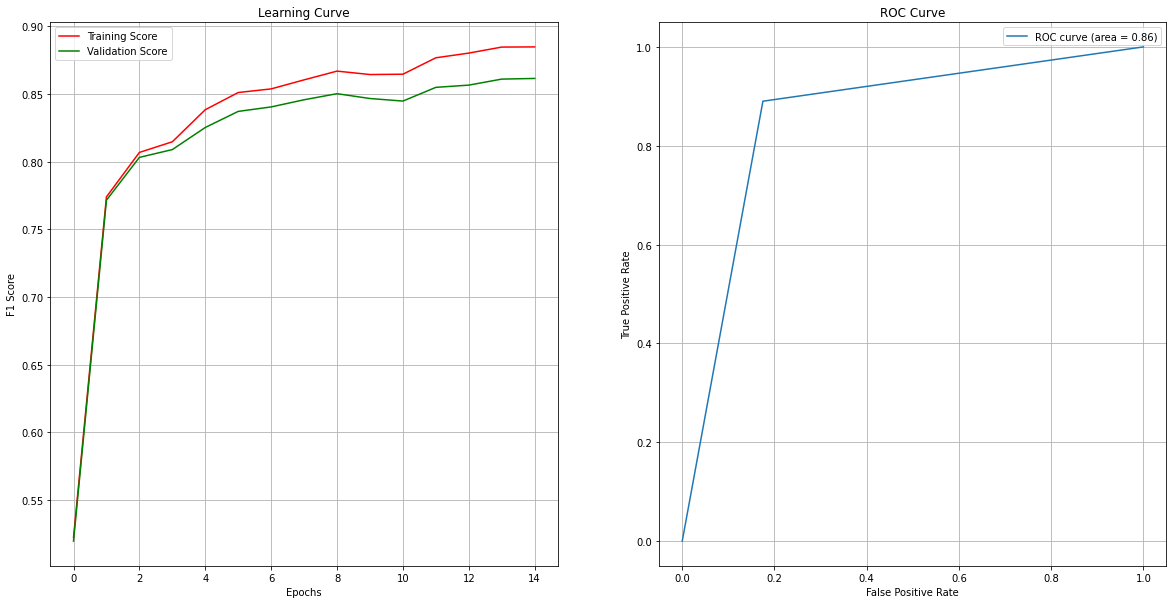

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc



fp,tp,_ = roc_curve(y_actual, y_predicted)
roc_auc = auc(fp,tp)

_, axes = plt.subplots(1,2,figsize=(20,10))
axes[0].set_title("Learning Curve")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("F1 Score")
axes[0].grid()

axes[0].plot(epoch_sizes, train_scores, color="r", label="Training Score")
axes[0].plot(epoch_sizes, val_scores, color="g", label="Validation Score")
axes[0].legend(loc="best")

axes[1].set_title("ROC Curve")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].grid()
axes[1].plot(fp, tp, label='ROC curve (area = %0.2f)' % roc_auc)
axes[1].legend(loc = "best")


In [ ]:
def objective_using_attention(trial):

    parameters = {
        'lr': trial.suggest_loguniform('learning_rate',1e-4,1e-2),
        'cell_type': trial.suggest_categorical("cell_type",["LSTM","GRU"]),
        'input_size': 300,
        'hidden_size': trial.suggest_int("hidden_size",16,64),
        'num_layers': trial.suggest_int("num_layers",1,10),
        'dropout': trial.suggest_loguniform("dropout",0.01,0.08),
        'skip_connections': trial.suggest_categorical("skip_connections",[True,False]),
        'attention': True
    }
    EPOCH = 15


    model= RNN(parameters,vec)

    _,f1_measure = Train_Network(train_dataloader,validation_dataloader,EPOCH,parameters['lr'],model)

    return f1_measure

###Searching for the best model: Using Attention

####Optuna Results:

In [ ]:
study = optuna.create_study(direction = "maximize", sampler = optuna.samplers.TPESampler())
study.optimize(objective_using_attention, n_trials = 50)

[I 2023-01-18 01:19:19,733] A new study created in memory with name: no-name-d6f0b69f-9767-45f2-8c35-3a4a72fce995
<ipython-input-15-03f65665c7c2>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lr': trial.suggest_loguniform('learning_rate',1e-4,1e-2),
<ipython-input-15-03f65665c7c2>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'dropout': trial.suggest_loguniform("dropout",0.01,0.08),
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.022555079935109853 and num_layers=1
  warn

Using cuda


<ipython-input-9-5f83bf2eb6bd>:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weight_vector = softmax(torch.matmul(out[i,0:-2,:],out[i,-1,:]))        #Compute weight vector
[I 2023-01-18 01:24:53,545] Trial 0 finished with value: 0.8774313926696777 and parameters: {'learning_rate': 0.006972070030461936, 'cell_type': 'GRU', 'hidden_size': 21, 'num_layers': 3, 'dropout': 0.022555079935109853, 'skip_connections': False}. Best is trial 0 with value: 0.8774313926696777.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.02793827916260979 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-18 01:30:14,107] Trial 1 finished with value: 0.8601567149162292 and parameters: {'learning_rate': 0.00011600020640934742, 'cell_type': 'LSTM', 'hidden_size': 21, 'num_layers': 3, 'dropout': 0.02793827916260979, 'skip_connections': True}. Best is trial 0 with value: 0.8774313926696777.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.020086317463277742 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-18 01:35:40,534] Trial 2 finished with value: 0.8821703195571899 and parameters: {'learning_rate': 0.002555562286057283, 'cell_type': 'LSTM', 'hidden_size': 24, 'num_layers': 3, 'dropout': 0.020086317463277742, 'skip_connections': False}. Best is trial 2 with value: 0.8821703195571899.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.014841164029774784 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-18 01:44:42,988] Trial 3 finished with value: 0.8820549845695496 and parameters: {'learning_rate': 0.000332459912615078, 'cell_type': 'GRU', 'hidden_size': 60, 'num_layers': 3, 'dropout': 0.014841164029774784, 'skip_connections': False}. Best is trial 2 with value: 0.8821703195571899.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.0146051285042776 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-18 01:49:45,399] Trial 4 finished with value: 0.8686731457710266 and parameters: {'learning_rate': 0.00015086718131912544, 'cell_type': 'GRU', 'hidden_size': 19, 'num_layers': 2, 'dropout': 0.0146051285042776, 'skip_connections': True}. Best is trial 2 with value: 0.8821703195571899.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.02051594089032721 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-18 01:58:33,143] Trial 5 finished with value: 0.883770227432251 and parameters: {'learning_rate': 0.0008597490589482921, 'cell_type': 'LSTM', 'hidden_size': 57, 'num_layers': 3, 'dropout': 0.02051594089032721, 'skip_connections': False}. Best is trial 5 with value: 0.883770227432251.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.019873999051957945 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-18 02:08:33,826] Trial 6 finished with value: 0.8697522282600403 and parameters: {'learning_rate': 0.007556848437982313, 'cell_type': 'GRU', 'hidden_size': 54, 'num_layers': 6, 'dropout': 0.019873999051957945, 'skip_connections': True}. Best is trial 5 with value: 0.883770227432251.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.030957846525667816 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-18 02:19:08,185] Trial 7 finished with value: 0.8792474865913391 and parameters: {'learning_rate': 0.00029517559104624234, 'cell_type': 'GRU', 'hidden_size': 59, 'num_layers': 6, 'dropout': 0.030957846525667816, 'skip_connections': False}. Best is trial 5 with value: 0.883770227432251.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.0660112842302449 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-18 02:32:37,259] Trial 8 finished with value: 0.8766087293624878 and parameters: {'learning_rate': 0.00012224797544645565, 'cell_type': 'GRU', 'hidden_size': 62, 'num_layers': 10, 'dropout': 0.0660112842302449, 'skip_connections': False}. Best is trial 5 with value: 0.883770227432251.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.011983359612956474 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-18 02:38:55,013] Trial 9 finished with value: 0.8792362213134766 and parameters: {'learning_rate': 0.0008325571692510869, 'cell_type': 'GRU', 'hidden_size': 28, 'num_layers': 5, 'dropout': 0.011983359612956474, 'skip_connections': True}. Best is trial 5 with value: 0.883770227432251.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.04615717840899366 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-18 02:49:12,806] Trial 10 finished with value: 0.6608508825302124 and parameters: {'learning_rate': 0.0012076937379294419, 'cell_type': 'LSTM', 'hidden_size': 45, 'num_layers': 9, 'dropout': 0.04615717840899366, 'skip_connections': False}. Best is trial 5 with value: 0.883770227432251.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.036532816926773785 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-18 02:54:55,370] Trial 11 finished with value: 0.8749386668205261 and parameters: {'learning_rate': 0.0019744081146915353, 'cell_type': 'LSTM', 'hidden_size': 35, 'num_layers': 1, 'dropout': 0.036532816926773785, 'skip_connections': False}. Best is trial 5 with value: 0.883770227432251.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.019598459177600235 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-18 03:03:16,982] Trial 12 finished with value: 0.8793131709098816 and parameters: {'learning_rate': 0.0027841765390345693, 'cell_type': 'LSTM', 'hidden_size': 46, 'num_layers': 5, 'dropout': 0.019598459177600235, 'skip_connections': False}. Best is trial 5 with value: 0.883770227432251.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.015993356742385428 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-18 03:10:01,808] Trial 13 finished with value: 0.8760656118392944 and parameters: {'learning_rate': 0.0031649504662040677, 'cell_type': 'LSTM', 'hidden_size': 35, 'num_layers': 4, 'dropout': 0.015993356742385428, 'skip_connections': False}. Best is trial 5 with value: 0.883770227432251.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.02567585814313459 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-18 03:17:13,762] Trial 14 finished with value: 0.8777340054512024 and parameters: {'learning_rate': 0.0007140129804061089, 'cell_type': 'LSTM', 'hidden_size': 50, 'num_layers': 1, 'dropout': 0.02567585814313459, 'skip_connections': False}. Best is trial 5 with value: 0.883770227432251.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.010945482666570522 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-18 03:24:35,260] Trial 15 finished with value: 0.8442820310592651 and parameters: {'learning_rate': 0.0014554878702349948, 'cell_type': 'LSTM', 'hidden_size': 30, 'num_layers': 8, 'dropout': 0.010945482666570522, 'skip_connections': False}. Best is trial 5 with value: 0.883770227432251.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.04258844475493185 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-18 03:33:15,559] Trial 16 finished with value: 0.8802893757820129 and parameters: {'learning_rate': 0.0004974382935869302, 'cell_type': 'LSTM', 'hidden_size': 41, 'num_layers': 7, 'dropout': 0.04258844475493185, 'skip_connections': False}. Best is trial 5 with value: 0.883770227432251.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.07951934997591376 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-18 03:38:45,419] Trial 17 finished with value: 0.8790938854217529 and parameters: {'learning_rate': 0.004192516187421289, 'cell_type': 'LSTM', 'hidden_size': 16, 'num_layers': 4, 'dropout': 0.07951934997591376, 'skip_connections': False}. Best is trial 5 with value: 0.883770227432251.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.019323399993300412 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-18 03:46:45,471] Trial 18 finished with value: 0.8784822225570679 and parameters: {'learning_rate': 0.0016774670262399035, 'cell_type': 'LSTM', 'hidden_size': 55, 'num_layers': 2, 'dropout': 0.019323399993300412, 'skip_connections': True}. Best is trial 5 with value: 0.883770227432251.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.030727955683446887 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-18 03:52:24,850] Trial 19 finished with value: 0.8772459626197815 and parameters: {'learning_rate': 0.004790658618331864, 'cell_type': 'LSTM', 'hidden_size': 26, 'num_layers': 4, 'dropout': 0.030727955683446887, 'skip_connections': False}. Best is trial 5 with value: 0.883770227432251.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.015917286781724414 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-18 03:58:13,590] Trial 20 finished with value: 0.8784576058387756 and parameters: {'learning_rate': 0.0006119296801409996, 'cell_type': 'LSTM', 'hidden_size': 34, 'num_layers': 2, 'dropout': 0.015917286781724414, 'skip_connections': False}. Best is trial 5 with value: 0.883770227432251.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.013508326235396093 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-18 04:07:27,153] Trial 21 finished with value: 0.8777919411659241 and parameters: {'learning_rate': 0.0003282911422038549, 'cell_type': 'GRU', 'hidden_size': 64, 'num_layers': 3, 'dropout': 0.013508326235396093, 'skip_connections': False}. Best is trial 5 with value: 0.883770227432251.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.017375580878447747 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-18 04:16:10,627] Trial 22 finished with value: 0.8794453144073486 and parameters: {'learning_rate': 0.00023519081559688406, 'cell_type': 'GRU', 'hidden_size': 57, 'num_layers': 3, 'dropout': 0.017375580878447747, 'skip_connections': False}. Best is trial 5 with value: 0.883770227432251.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.023463623716800875 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-18 04:24:37,759] Trial 23 finished with value: 0.8819076418876648 and parameters: {'learning_rate': 0.00042690801734938423, 'cell_type': 'GRU', 'hidden_size': 50, 'num_layers': 4, 'dropout': 0.023463623716800875, 'skip_connections': False}. Best is trial 5 with value: 0.883770227432251.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.013224866448368448 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-18 04:32:45,820] Trial 24 finished with value: 0.8770669102668762 and parameters: {'learning_rate': 0.0010189187844629143, 'cell_type': 'LSTM', 'hidden_size': 60, 'num_layers': 1, 'dropout': 0.013224866448368448, 'skip_connections': False}. Best is trial 5 with value: 0.883770227432251.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.022224927257124345 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-18 04:40:33,665] Trial 25 finished with value: 0.8772203922271729 and parameters: {'learning_rate': 0.0001966766332064184, 'cell_type': 'LSTM', 'hidden_size': 52, 'num_layers': 2, 'dropout': 0.022224927257124345, 'skip_connections': False}. Best is trial 5 with value: 0.883770227432251.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.0176815891277386 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


[I 2023-01-18 04:48:43,364] Trial 26 finished with value: 0.880402684211731 and parameters: {'learning_rate': 0.0021983255376302486, 'cell_type': 'GRU', 'hidden_size': 43, 'num_layers': 5, 'dropout': 0.0176815891277386, 'skip_connections': True}. Best is trial 5 with value: 0.883770227432251.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.010254590934035286 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Using cuda


After running optuna for 27 trials, the model which produced the highest f1 score on the test set was the following:

```
parameters = {
    'learning_rate': 0.0008597490589482921,
    'cell_type': 'LSTM',
    'input_size': 300,
    'hidden_size': 57,
    'num_layers': 3,
    'dropout': 0.02051594089032721,
    'skip_connections' : False
}

```




####Plotting Learning Curve & ROC Curve for the produced model

In [ ]:
parameters = {
    'lr': 0.0008597490589482921,
    'cell_type': 'LSTM',
    'input_size': 300,
    'hidden_size': 57,
    'num_layers': 3,
    'dropout': 0.02051594089032721,
    'skip_connections' : False,
    'attention' : True
}

#{'learning_rate': 0.0008597490589482921, 'cell_type': 'LSTM', 'hidden_size': 57, 'num_layers': 3, 'dropout': 0.02051594089032721, 'skip_connections': False}

net = RNN(parameters,vec)
print(net)

EPOCH = 7
trained_model, avg_losses, epoch_sizes, val_scores, train_scores = Train_Network(train_dataloader,validation_dataloader,EPOCH, parameters['lr'], net,info = True)

RNN(
  (embedding): Embedding(400000, 300)
  (rnn_layers): ModuleList(
    (0): LSTM(300, 57, batch_first=True, dropout=0.02051594089032721, bidirectional=True)
    (1): LSTM(114, 57, batch_first=True, dropout=0.02051594089032721, bidirectional=True)
    (2): LSTM(114, 57, batch_first=True, dropout=0.02051594089032721, bidirectional=True)
  )
  (out): Linear(in_features=228, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Using cuda


<ipython-input-9-5f83bf2eb6bd>:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weight_vector = softmax(torch.matmul(out[i,0:-2,:],out[i,-1,:]))        #Compute weight vector


In [ ]:
precision, recall, f1 = Test_Network(test_dataloader,trained_model)
print("Precision: ",precision.item())
print("Recall: ",recall.item())
print("f1 measure: ",f1.item())

y_predicted = make_prediction(test_dataloader,trained_model)
y_actual = np.asarray(test_dataset.getLabels())

<ipython-input-9-5f83bf2eb6bd>:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weight_vector = softmax(torch.matmul(out[i,0:-2,:],out[i,-1,:]))        #Compute weight vector


Precision:  0.8311057686805725
Recall:  0.9242501258850098
f1 measure:  0.8737862706184387


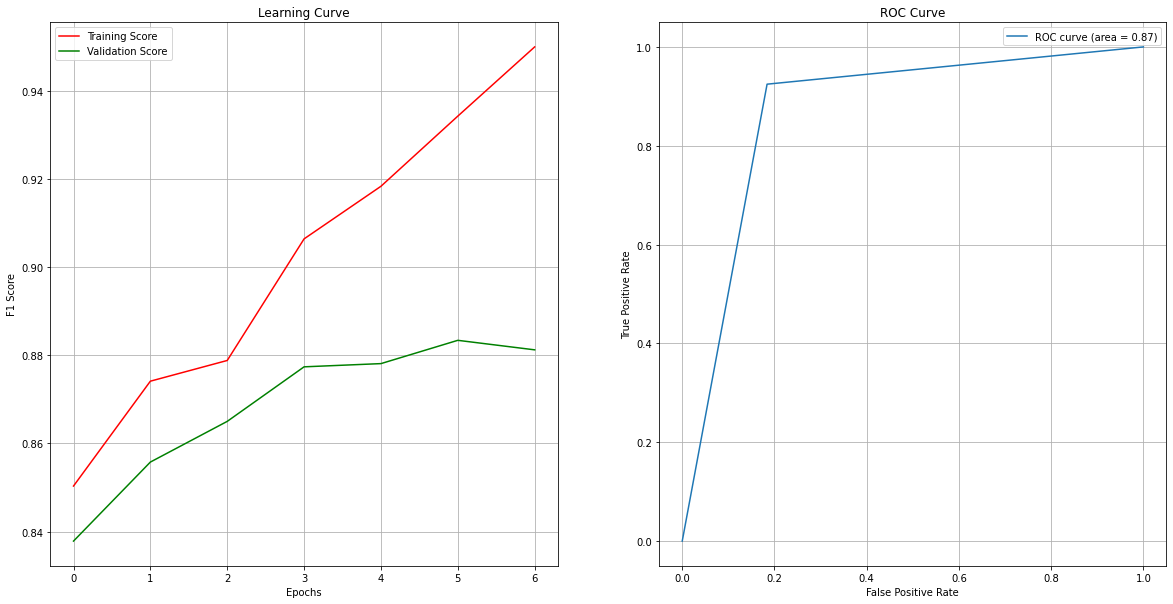

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


fp,tp,_ = roc_curve(y_actual, y_predicted)
roc_auc = auc(fp,tp)

_, axes = plt.subplots(1,2,figsize=(20,10))
axes[0].set_title("Learning Curve")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("F1 Score")
axes[0].grid()

axes[0].plot(epoch_sizes, train_scores, color="r", label="Training Score")
axes[0].plot(epoch_sizes, val_scores, color="g", label="Validation Score")
axes[0].legend(loc="best")

axes[1].set_title("ROC Curve")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].grid()
axes[1].plot(fp, tp, label='ROC curve (area = %0.2f)' % roc_auc)
axes[1].legend(loc = "best")


After running optuna for 27 trials, the model which produced the highest f1 score on the test set was the following:

```
parameters = {
    'lr': 0.0005448990796029992,
    'cell_type': 'GRU',
    'input_size': 300,
    'hidden_size': 35,
    'num_layers': 7,
    'dropout': 0.015853786329403766,
    'skip_connections' : True
}
```